In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Activation,Dropout, Flatten, Dense, Input
from keras.models import load_model, Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import cv2
from keras.applications.resnet50 import ResNet50,preprocess_input

Using TensorFlow backend.


In [2]:
loc_ref = '/content/drive/My Drive/birdspecies.zip'
zip_ref = zipfile.ZipFile(loc_ref,'r')
zip_ref.extractall('/birds')
zip_ref.close()

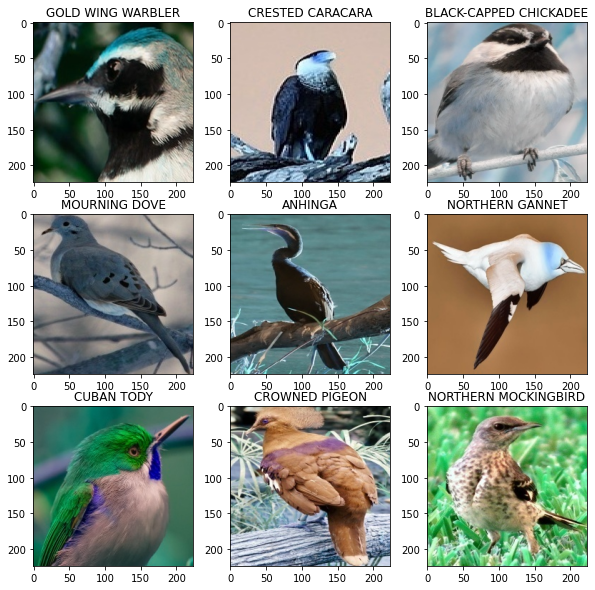

In [3]:
train_dir=r'/birds/train'
train_class = np.array([item for item in os.listdir(train_dir)])
fig=plt.figure(figsize=(10,10))
columns = 3
rows = 3
for i in range(1,10):
    
    img=fig.add_subplot(rows, columns, i)
    k = cv2.imread(train_dir+ '/'+ train_class[i] + f'/00{i}.jpg')
    plt.imshow(k)
    img.set_title(train_class[i])
plt.show()

In [6]:

train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = 'nearest',
    zoom_range = 0.2,
    shear_range = 0.2,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    rotation_range = 40,
    preprocessing_function=preprocess_input,
    )

train_generator = train_datagen.flow_from_directory(
    '/birds/train',
    batch_size = 10,
    target_size = (224,224),
    class_mode = 'categorical',
    )


validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)
validation_generator = validation_datagen.flow_from_directory(
    '/birds/valid',
    batch_size = 10,
    target_size = (224,224),
    class_mode = 'categorical',
    )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        '/birds/test',
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 27503 images belonging to 200 classes.
Found 1000 images belonging to 200 classes.
Found 1000 images belonging to 200 classes.


In [7]:

pretrained_model=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
for layer in pretrained_model.layers:
  layer.trainable=False
x = pretrained_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(200,activation='softmax')(x)
model =keras.models.Model(pretrained_model.input,outputs=x)
model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________

In [8]:
model.fit_generator(train_generator,epochs=2,validation_data=validation_generator)

Epoch 1/2
2751/2751 [==============================] - 6553s 2s/step - loss: 20.0971 - accuracy: 0.4494 - val_loss: 16.5071 - val_accuracy: 0.7620
Epoch 2/2
2751/2751 [==============================] - 6381s 2s/step - loss: 16.9745 - accuracy: 0.6393 - val_loss: 9.3388 - val_accuracy: 0.8120


In [11]:
score = model.evaluate(test_generator, verbose=0)
print('Test data accuracy:', score[1])

Test data accuracy: 0.8420000076293945
